# Travel Churn Prediction - Context
* **Business problem**: Identify users likely to churn based on their historical actions and demographic information, enabling proactive retention efforts.
* **Recommendation**: Implement binary classification models to predict customer churn, picking model(s) that perform best on recall/F1 metrics.
* **Application**: Use churn predictions to assign targeted promotional or marketing strategies aimed at retaining at-risk customers.
* **Expected result**: Accurately identify >77% of likely-to-churn customers, improving retention strategies and reducing churn.




---


Please refer to this link for deeper data exploration and analysis using Tableau: https://silver-file-63d.notion.site/Traveler-Churn-Analysis-Tableau-13658f205ea780a6a763e989904972cf


Data source:
https://www.kaggle.com/datasets/tejashvi14/tour-travels-customer-churn-prediction/data

## Download ecommerce dataset

In [3]:
import numpy as np
import pandas as pd

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Customertravel.csv to Customertravel (1).csv


In [93]:
df = pd.read_csv('Customertravel.csv')

## Data exploratory

### **Data Cleaning**

* **NaN values**: no null values present.

### **Initial Observations**

* Out of 954 customers, 23% churned, highlighting the need for a model with accuracy greater than 77% to outperform the baseline of predicting no churn.
* The age distribution ranges from 27 to 38 years.
* Over 60% of customers are non-frequent flyers.
* Less than 20% of users identify as high-income.
* Service usage is right-skewed, with a median of 2, indicating that 50% of customers booked 2 services in recent years.


In [94]:
df.head()

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    object
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Target                      954 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 52.3+ KB


In [96]:
df.describe().round(2)

,Age,ServicesOpted,Target
count,954.00,954.00,954.00
mean,32.11,2.44,0.23
std,3.34,1.61,0.42
min,27.00,1.00,0.00
25%,30.00,1.00,0.00
50%,31.00,2.00,0.00
75%,35.00,4.00,0.00
max,38.00,6.00,1.00


In [97]:
df.isnull().sum()

,0
Age,0
FrequentFlyer,0
AnnualIncomeClass,0
ServicesOpted,0
AccountSyncedToSocialMedia,0
BookedHotelOrNot,0
Target,0


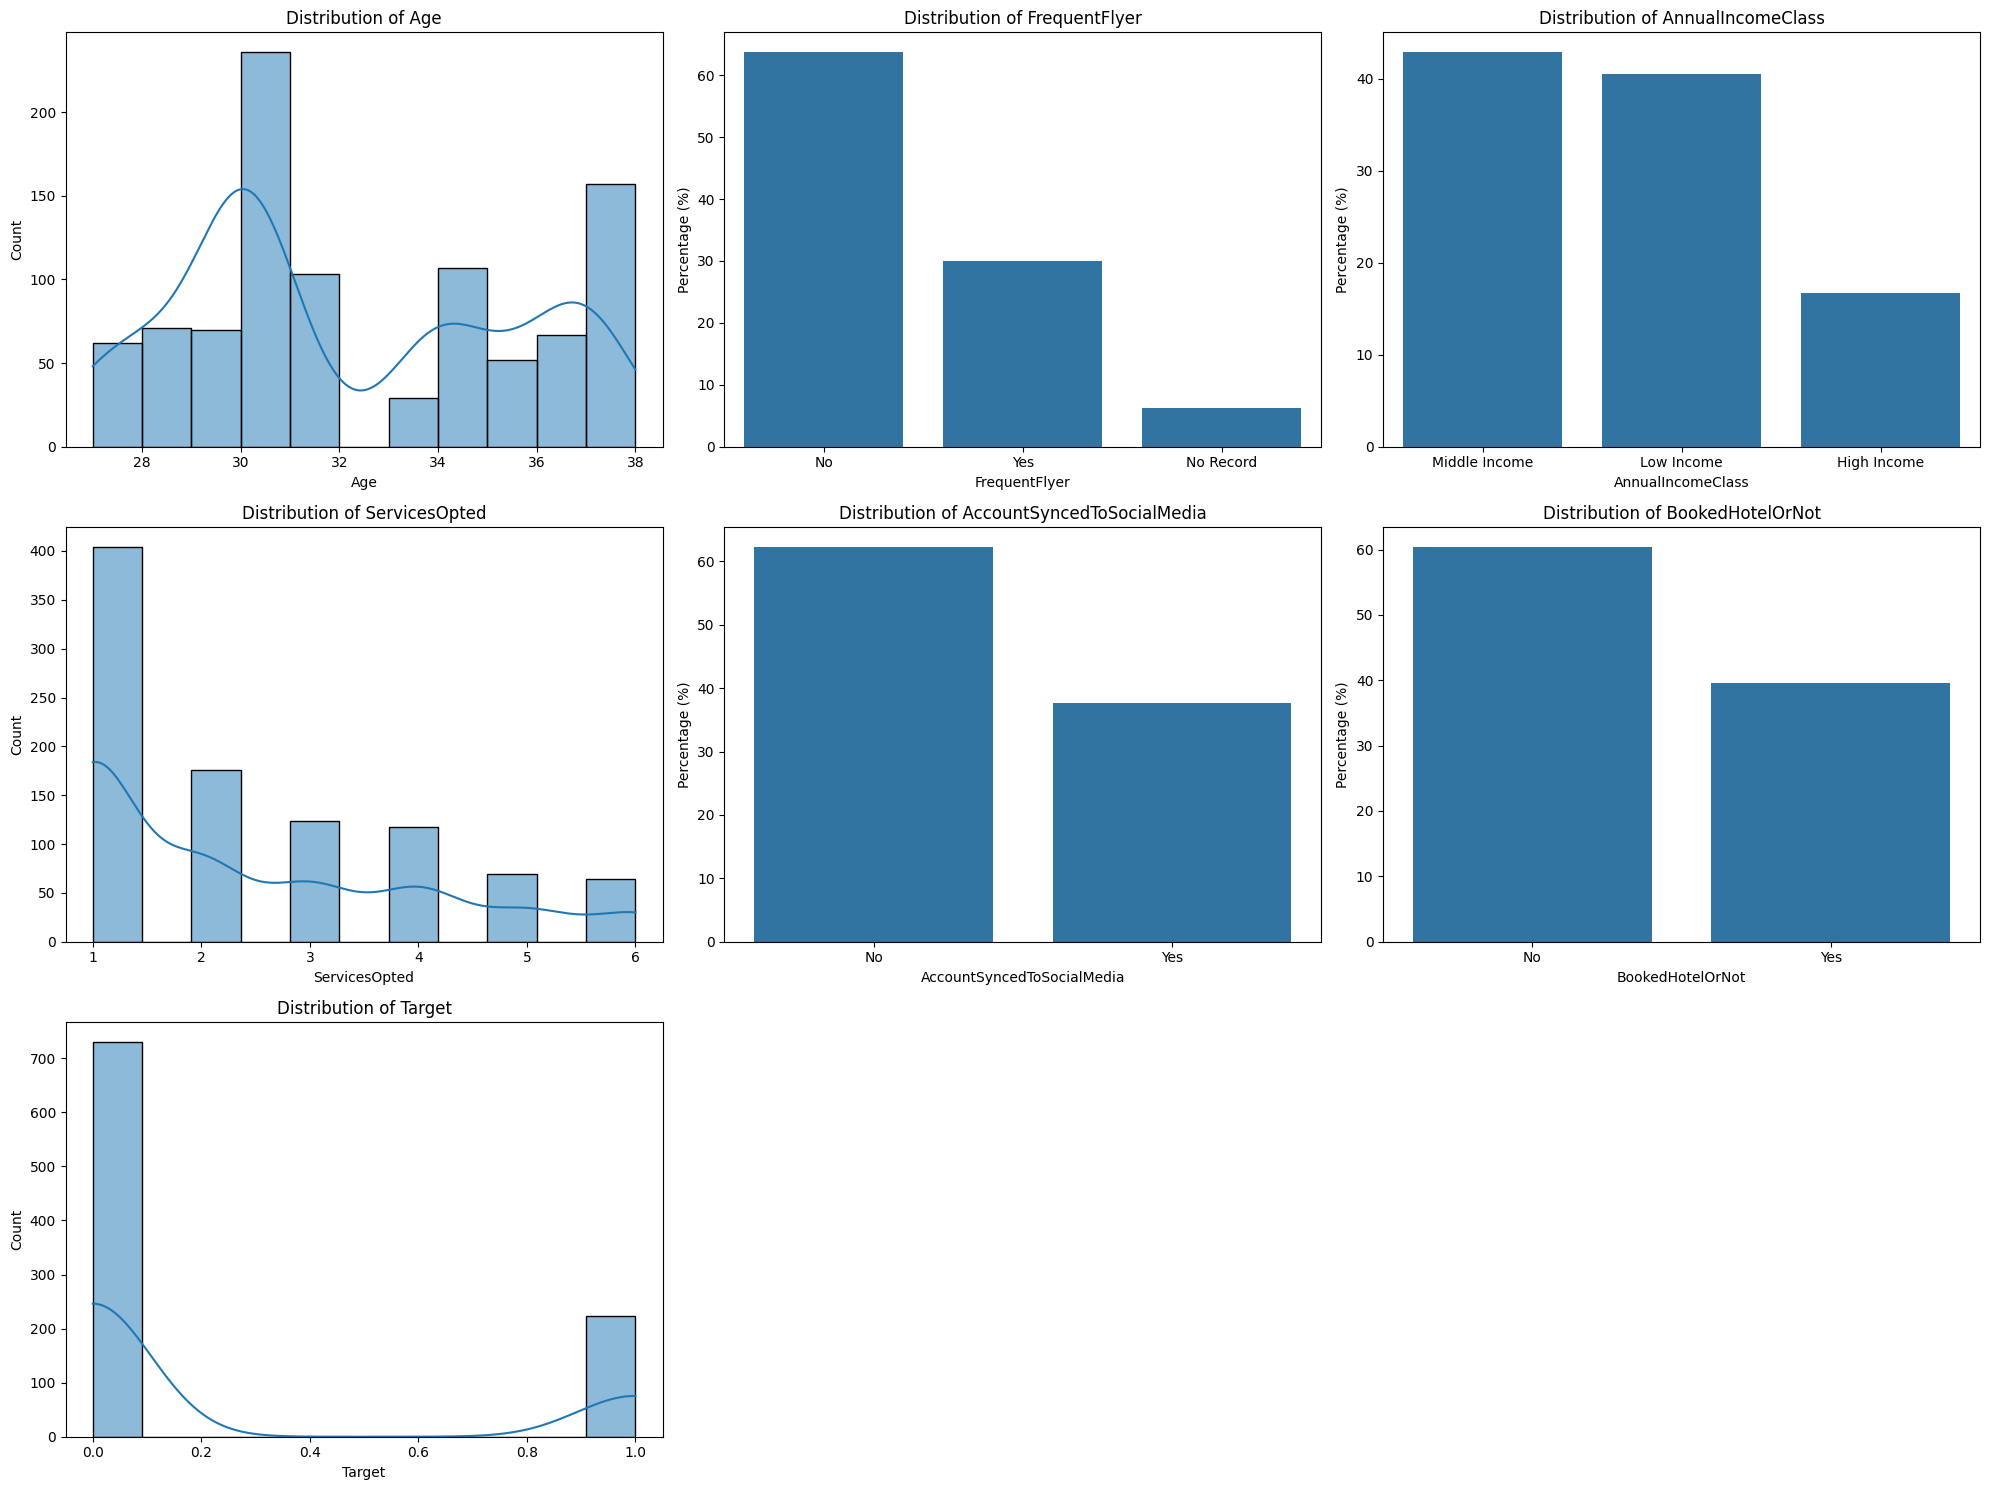

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Number of rows and columns for the grid
rows, cols = 3, 3

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten the 3x4 grid to iterate easily

# Loop through columns in df_hist and plot on each subplot
for i, column in enumerate(df.columns):
    # Check if the column is categorical or Churn
    if df[column].dtype == "object" or column == "Churn":
        # Calculate percentage of each category
        percentage = df[column].value_counts(normalize=True) * 100

        # Plot as a bar chart
        sns.barplot(x=percentage.index, y=percentage.values, ax=axes[i])
        axes[i].set_ylabel('Percentage (%)')
    else:
        # For numeric columns, plot the distribution as a histogram with kde
        sns.histplot(df[column], kde=True, ax=axes[i])
        axes[i].set_ylabel('Count')

    axes[i].set_title(f'Distribution of {column}')

# Remove any unused subplots (if there are fewer than 12 columns)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




### **A Question to clarify: How to define "Churn" (Target = 1)**
  - **Hypothesis 1 Time-Based Inactivity**: Users who haven't book the service for x period of time
    
    According to the box plot of "ServicesOpted by Target" below,
    - Median of Churned users is equal to that of No Churn
    - Interquatile range of Churned users is larger than that of No Churn

  These data point **does not support** the hypothesis that Churn definition is related to Time-Based Inactivity

  - **Hypothesis 2 Drop in Usage or Engagement**: Users who haven't sign-in or engage (not necessarily book service) for x period of time

  - **Hypothesis 3 Application uninstalled**: Users who delete the app on their mobile phone

  - **Hypothesis 4 Subscription Cancellations**: Users who unsubscribed to our marketing communication

For hypothesis 2, 3, and 4, there is insufficient data to prove which one is more likely to be the definition.

Therefore, in this analysis, I assume hypothesis 2: Drop in Usage or Engagement are the churn definition.

  



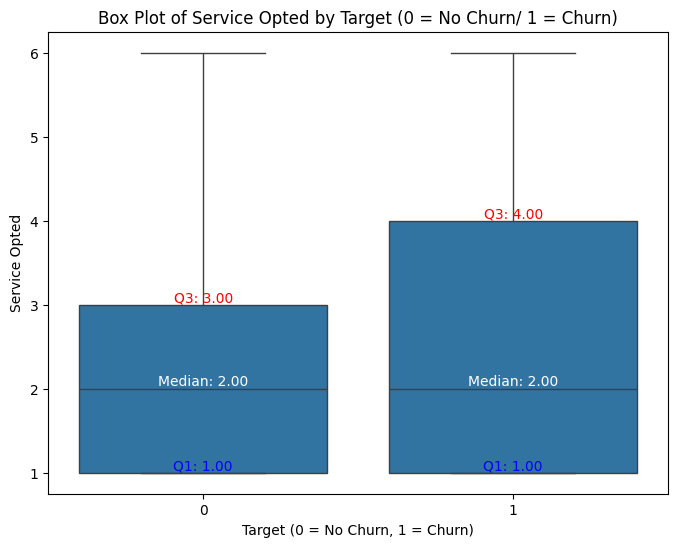

In [99]:
plt.figure(figsize=(8,6))
ax = sns.boxplot(x='Target', y='ServicesOpted', data=df)

plt.title('Box Plot of Service Opted by Target (0 = No Churn/ 1 = Churn)')
plt.xlabel('Target (0 = No Churn, 1 = Churn)')
plt.ylabel('Service Opted')

# Annotate the boxplot
for i, target_value in enumerate(df['Target'].unique()):
    # Get the relevant subset of the data
    subset = df[df['Target'] == target_value]['ServicesOpted']

    # Calculate the percentiles
    q25 = subset.quantile(0.25)
    q50 = subset.quantile(0.50)
    q75 = subset.quantile(0.75)

    # Annotate the percentiles on the plot
    ax.text(i, q25, f'Q1: {q25:.2f}', horizontalalignment='center', verticalalignment='bottom', color='blue', fontsize=10)
    ax.text(i, q50, f'Median: {q50:.2f}', horizontalalignment='center', verticalalignment='bottom', color='white', fontsize=10)
    ax.text(i, q75, f'Q3: {q75:.2f}', horizontalalignment='center', verticalalignment='bottom', color='red', fontsize=10)

plt.show()

# Correlation and VIF analysis

- no highly correlated numerical variable

In [100]:
df_numeric = df.select_dtypes(exclude=['object'])

In [101]:
correlation_matrix = df_numeric.corr()
correlation_matrix

,Age,ServicesOpted,Target
Age,1.000000,-0.012422,-0.131534
ServicesOpted,-0.012422,1.000000,0.038646
Target,-0.131534,0.038646,1.000000


In [102]:
# Calculate VIF (this will be important for Linear model (Logistic regression)

from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = df.select_dtypes(include=[float, int]).dropna() # Select numeric columns and drop NAs
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

         feature       VIF
0            Age  3.400972
1  ServicesOpted  3.227656
2         Target  1.289491


# Standardizing numerical features and Encoding categorical features

In [103]:
# Selecting numerical data
categorical_data = df[['FrequentFlyer','AnnualIncomeClass', 'AccountSyncedToSocialMedia', 'BookedHotelOrNot']]
categorical_data

,FrequentFlyer,AnnualIncomeClass,AccountSyncedToSocialMedia,BookedHotelOrNot
0,No,Middle Income,No,Yes
1,Yes,Low Income,Yes,No
2,No,Middle Income,Yes,No
3,No,Middle Income,No,No
4,No,Low Income,No,No
...,...,...,...,...
949,Yes,Low Income,No,No
950,No,Middle Income,No,Yes
951,No,Middle Income,No,No
952,No,Low Income,Yes,Yes


In [104]:
numerical_data = df[['Age', 'ServicesOpted']]
numerical_data

,Age,ServicesOpted
0,34,6
1,34,5
2,37,3
3,30,2
4,30,1
...,...,...
949,31,1
950,30,5
951,37,4
952,30,1


In [105]:
from sklearn.preprocessing import StandardScaler

# Applying StandardScaler
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(numerical_data)

# Convert to DataFrame
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_data.columns)

# Display the first few rows of the scaled dataframe
print(numerical_scaled_df.head())

        Age  ServicesOpted
0  0.566904       2.219330
1  0.566904       1.596429
2  1.466282       0.350627
3 -0.632267      -0.272274
4 -0.632267      -0.895175


In [106]:
from sklearn.preprocessing import OneHotEncoder
### WRITE CODE TO PERFORM ONE-HOT CODING ON "Year" AND "Status" ###

from sklearn.preprocessing import OneHotEncoder

# Applying OneHotEncoder with drop='first' to drop one column per category
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_encoded = encoder.fit_transform(categorical_data)

In [107]:
# Convert to DataFrame
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_data.columns))

# Display the first few rows of the encoded dataframe
print(categorical_encoded_df.head())

   FrequentFlyer_No Record  FrequentFlyer_Yes  AnnualIncomeClass_Low Income  \
0                      0.0                0.0                           0.0   
1                      0.0                1.0                           1.0   
2                      0.0                0.0                           0.0   
3                      0.0                0.0                           0.0   
4                      0.0                0.0                           1.0   

   AnnualIncomeClass_Middle Income  AccountSyncedToSocialMedia_Yes  \
0                              1.0                             0.0   
1                              0.0                             1.0   
2                              1.0                             1.0   
3                              1.0                             0.0   
4                              0.0                             0.0   

   BookedHotelOrNot_Yes  
0                   1.0  
1                   0.0  
2                   0.0  


In [108]:
## Combine numerical and encoded categorical data into one dataframe ##

# Resetting index to align the dataframes before combining
categorical_encoded_df.reset_index(drop=True, inplace=True)
numerical_scaled_df.reset_index(drop=True, inplace=True)

# Combining encoded categorical data and scaled numerical data
combined_df = pd.concat([numerical_scaled_df, categorical_encoded_df, df['Target']], axis=1)

# Display the first few rows of the combined dataframe
print(combined_df.head())

        Age  ServicesOpted  FrequentFlyer_No Record  FrequentFlyer_Yes  \
0  0.566904       2.219330                      0.0                0.0   
1  0.566904       1.596429                      0.0                1.0   
2  1.466282       0.350627                      0.0                0.0   
3 -0.632267      -0.272274                      0.0                0.0   
4 -0.632267      -0.895175                      0.0                0.0   

   AnnualIncomeClass_Low Income  AnnualIncomeClass_Middle Income  \
0                           0.0                              1.0   
1                           1.0                              0.0   
2                           0.0                              1.0   
3                           0.0                              1.0   
4                           1.0                              0.0   

   AccountSyncedToSocialMedia_Yes  BookedHotelOrNot_Yes  Target  
0                             0.0                   1.0       0  
1             

## Train the data with classification models

In [109]:
X = combined_df.drop('Target', axis=1)  # drop the target variable from the features
y = combined_df['Target']  # target variable

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Logistic Regression

In [111]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Decision tree

In [112]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
model_dt = DecisionTreeClassifier()

# Fit the model
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

### Random forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
model_rf = RandomForestClassifier()

# Fit the model
model_rf.fit(X_train, y_train)

RandomForestClassifier()

### K Neighbor classifier

In [114]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
model_knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

### Gradient Boosting Classifier

In [115]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the GBM model
model_gbm = GradientBoostingClassifier()
# Fit the model
model_gbm.fit(X_train, y_train)

GradientBoostingClassifier()

### Multi-layer Perceptron Neural Network

In [116]:
from sklearn.neural_network import MLPClassifier

# Initialize the Neural Network model
model_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)

# Fit the model
model_nn.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=300)

## Predict X_test with the models

In [117]:
predicted = model.predict(X_test)

In [118]:
predicted_dt = model_dt.predict(X_test)

In [119]:
predicted_rf = model_rf.predict(X_test)

In [120]:
predicted_knn = model_knn.predict(X_test)

In [121]:
predicted_gbm = model_gbm.predict(X_test)

In [122]:
predicted_nn = model_nn.predict(X_test)

## Determine each model accuracy
* using 'Accuracy' metric
* using confusion matrix
* using K-folded cross validation

In [123]:
expected = y_test

In [124]:
wrong = [(p, e) for (p, e) in zip(predicted, expected) if p != e]

In [125]:
wrong_dt = [(p, e) for (p, e) in zip(predicted_dt, expected) if p != e]

In [126]:
wrong_rf = [(p, e) for (p, e) in zip(predicted_rf, expected) if p != e]

In [127]:
wrong_knn = [(p, e) for (p, e) in zip(predicted_knn, expected) if p != e]

In [128]:
wrong_gbm = [(p, e) for (p, e) in zip(predicted_gbm, expected) if p != e]

In [129]:
wrong_nn = [(p, e) for (p, e) in zip(predicted_nn, expected) if p != e]

### Models' Accuracy

In [130]:
logistic_regression_accuracy = 1 - (len(wrong) / len(expected))
logistic_regression_accuracy

0.8535564853556485

In [131]:
logistic_regression_accuracy = 1 - (len(wrong_dt) / len(expected))
logistic_regression_accuracy

0.895397489539749

In [132]:
logistic_regression_accuracy = 1 - (len(wrong_rf) / len(expected))
logistic_regression_accuracy

0.891213389121339

In [133]:
logistic_regression_accuracy = 1 - (len(wrong_knn) / len(expected))
logistic_regression_accuracy

0.8744769874476988

In [134]:
logistic_regression_accuracy = 1 - (len(wrong_gbm) / len(expected))
logistic_regression_accuracy

0.895397489539749

In [135]:
logistic_regression_accuracy = 1 - (len(wrong_nn) / len(expected))
logistic_regression_accuracy

0.8535564853556485

### Confusion Matrix

**Decision tree** has the highest True positive value, implying lowest recall (TP / (TP+FN)) rate. However, decision tree tends to overfit.

**Gradient boosting and Random forest** also perform similarly well in predicting true positive.

In [136]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true=expected, y_pred=predicted)
confusion_df = pd.DataFrame(confusion, index=range(2), columns=range(2))

In [137]:
confusion_dt = confusion_matrix(y_true=expected, y_pred=predicted_dt)
confusion_df_dt = pd.DataFrame(confusion_dt, index=range(2), columns=range(2))

In [138]:
confusion_rf = confusion_matrix(y_true=expected, y_pred=predicted_rf)
confusion_df_rf = pd.DataFrame(confusion_rf, index=range(2), columns=range(2))

In [139]:
confusion_knn = confusion_matrix(y_true=expected, y_pred=predicted_knn)
confusion_df_knn = pd.DataFrame(confusion_knn, index=range(2), columns=range(2))

In [140]:
confusion_gbm = confusion_matrix(y_true=expected, y_pred=predicted_gbm)
confusion_df_gbm = pd.DataFrame(confusion_gbm, index=range(2), columns=range(2))

In [141]:
confusion_nn = confusion_matrix(y_true=expected, y_pred=predicted_nn)
confusion_df_nn = pd.DataFrame(confusion_nn, index=range(2), columns=range(2))

In [142]:
# confusion matrix for logistic regression
confusion_df

,0,1
0,177,14
1,21,27


In [143]:
# confusion matrix for decision tree
confusion_df_dt

,0,1
0,180,11
1,14,34


In [144]:
# confusion matrix for random forest
confusion_df_rf

,0,1
0,181,10
1,16,32


In [145]:
# confusion matrix for k neighbors
confusion_df_knn

,0,1
0,180,11
1,19,29


In [146]:
# confusion matrix for gradient boosting
confusion_df_gbm

,0,1
0,181,10
1,15,33


In [147]:
# confusion matrix for MLP neural network
confusion_df_nn

,0,1
0,177,14
1,21,27


### K-folded cross validation

Perform k-fold cross validation to better understand models' performance while efficiently using the limited data.

- With k-fold cross validation, Decision Tree and Random Forest perform the best in both accuracy and recall metrics.
  - Decision Tree:
      - Accuracy - 88.67%
      - Recall - 73.33%
  - Random Forest:
      - Accuracy - 87.41%
      - Recall - 70.52%

In [148]:
from sklearn.model_selection import cross_val_score

# Set the number of folds for cross-validation
k = 5  # for 5-fold cross-validation

# Perform k-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=k, scoring='accuracy')
cv_scores_recall = cross_val_score(model, X_train, y_train, cv=k, scoring='recall')

# Print each fold's accuracy and the average accuracy across all folds
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Mean Recall: {np.mean(cv_scores_recall):.4f}")

Cross-Validation Accuracy Scores: [0.83216783 0.78321678 0.75524476 0.82517483 0.79020979]
Mean Accuracy: 0.7972
Mean Recall: 0.4437


In [149]:
from sklearn.model_selection import cross_val_score

# Set the number of folds for cross-validation
k = 5  # for 5-fold cross-validation; you can adjust as needed

# Perform k-fold cross-validation
cv_scores = cross_val_score(model_dt, X_train, y_train, cv=k, scoring='accuracy')
cv_scores_recall = cross_val_score(model_dt, X_train, y_train, cv=k, scoring='recall')

# Print each fold's accuracy and the average accuracy across all folds
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Mean Recall: {np.mean(cv_scores_recall):.4f}")

Cross-Validation Accuracy Scores: [0.91608392 0.86013986 0.8951049  0.87412587 0.88811189]
Mean Accuracy: 0.8867
Mean Recall: 0.7333


In [150]:
from sklearn.model_selection import cross_val_score

# Set the number of folds for cross-validation
k = 5  # for 5-fold cross-validation; you can adjust as needed

# Perform k-fold cross-validation
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=k, scoring='accuracy')
cv_scores_recall = cross_val_score(model_rf, X_train, y_train, cv=k, scoring='recall')


# Print each fold's accuracy and the average accuracy across all folds
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Mean Recall: {np.mean(cv_scores_recall):.4f}")

Cross-Validation Accuracy Scores: [0.87412587 0.87412587 0.88111888 0.86713287 0.87412587]
Mean Accuracy: 0.8741
Mean Recall: 0.7052


In [151]:
from sklearn.model_selection import cross_val_score

# Set the number of folds for cross-validation
k = 5  # for 5-fold cross-validation; you can adjust as needed

# Perform k-fold cross-validation
# Use scoring='accuracy' or another metric (e.g., 'f1') depending on your preference
cv_scores = cross_val_score(model_gbm, X_train, y_train, cv=k, scoring='accuracy')
cv_scores_recall = cross_val_score(model_gbm, X_train, y_train, cv=k, scoring='recall')

# Print each fold's accuracy and the average accuracy across all folds
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Mean Recall: {np.mean(cv_scores_recall):.4f}")

Cross-Validation Accuracy Scores: [0.8951049  0.8951049  0.86013986 0.86013986 0.87412587]
Mean Accuracy: 0.8769
Mean Recall: 0.6819


# Voting Classifiers

- Combines predictions from multiple models to make a final prediction. This **leads to a better generalization** than individual models, as it reduces the risk of overfitting or being biased by the flaws of a single model.

- Uses "**Soft voting**", average class probabilities across classifiers, to takes into account the confidence of the individual models.

- However, achieves 71% recall with combined model, no significant improvement from voting classifiers

In [152]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier()
clf3 = DecisionTreeClassifier()
eclf1 = VotingClassifier(estimators=[('gbm', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)

In [153]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       191
           1       0.72      0.71      0.72        48

    accuracy                           0.89       239
   macro avg       0.83      0.82      0.82       239
weighted avg       0.89      0.89      0.89       239



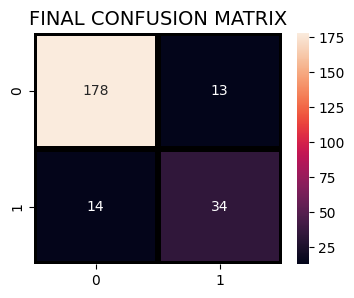

In [154]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, predictions),
                annot=True,fmt = "d",linecolor="k",linewidths=3)

plt.title("FINAL CONFUSION MATRIX",fontsize=14)
plt.show()

# SMOTE for oversampling

- SMOTE helps to balance the dataset by oversampling the minority class through synthetic data generation. Instead of duplicating minority class instances, SMOTE generates new, synthetic examples by interpolating between the instance and its neighbors.
- **Achieve 91% accuracy and 79% recall rate using SMOTE with Decision Tree**
- No improvement when using SMOTE on Random Forest

### SMOTE on Random Forest

In [157]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after resampling
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

# Train a classifier on the resampled data
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = model_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE:
Target
0    577
1    577
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       153
           1       0.66      0.71      0.68        38

    accuracy                           0.87       191
   macro avg       0.79      0.81      0.80       191
weighted avg       0.87      0.87      0.87       191



### SMOTE on Decision Tree

In [158]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after resampling
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

# Train a classifier on the resampled data
model_smote = DecisionTreeClassifier(random_state=42)
model_smote.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = model_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

Class distribution after SMOTE:
Target
0    577
1    577
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       153
           1       0.79      0.79      0.79        38

    accuracy                           0.92       191
   macro avg       0.87      0.87      0.87       191
weighted avg       0.92      0.92      0.92       191



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


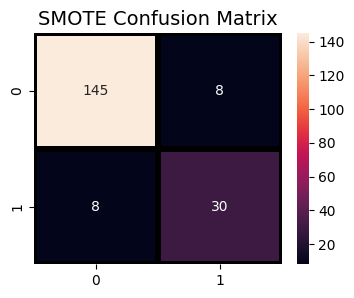

In [159]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)

plt.title("SMOTE Confusion Matrix",fontsize=14)
plt.show()